In [1]:
import os
# Ignore TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

from tensorflow.keras.datasets import imdb

from deepthink.layers import Embedding, GlobalAveragePooling1D, Dense
from deepthink.model import Model
from deepthink.optimizers import Adam
from deepthink.loss import BinaryCrossEntropy
from deepthink.activations import Sigmoid
from deepthink.utils import pad_sequences

# Set default matplotlib style
plt.style.use('ggplot')

## IMDB Sentiment Analysis

The purpose of this notebook is to demonstrate text-classification using [sentiment analysis](https://en.wikipedia.org/wiki/Sentiment_analysis). This example is inspired by [this](https://www.tensorflow.org/tutorials/keras/text_classification) TensorFlow tutorial.

#### IMDB Dataset

The dataset used is the [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/), which consists of 50,000 movie reviews from [imdb.com](https://www.imdb.com/) split into 25,000 for training and 25,000 for testing. Each review is classed as positive or negative (1 or 0 respectively) and the goal is to predict this from the review text. Reviews have been preprocessed, and each review is encoded as a sequence of word indexes (integers).

In [2]:
# Define the parameters
max_features = 10000  # Maximum vocab size
seq_len = 200  # Maximum length of each review
embedding_dim = 16
batch_size = 32
epochs = 10
learning_rate = 0.001

In [3]:
# Load the data
(train_text, train_labels), (X_test, y_test) = imdb.load_data(num_words=max_features)

# Reshape labels to column vector
train_labels = train_labels.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

print(train_text.shape, train_labels.shape)
print(X_test.shape, y_test.shape)

(25000,) (25000, 1)
(25000,) (25000, 1)


In [4]:
# View a sample review
sample = np.random.choice(train_text)
# Get the word index for each word in the review
word_to_idx = imdb.get_word_index()
# Create a reverse word index
idx_to_word = {idx: word for word, idx in word_to_idx.items()}

# Convert the review to text
review = ' '.join([idx_to_word.get(idx - 3, '?') for idx in sample])
print(review)

? yes some plots are a bit hard to follow and the bill does have a tendency to get violent but it is actually an engrossing show that i try not to miss a vast majority of the episodes are very exciting and quite tense and the acting is fairly good though i do miss ? taylor as inspector gina gold and todd ? as gabriel kent i will admit i prefer the older episodes to the newer episodes and it is a bit of a shame that the programme is now after the ? as i found it easier to watch when it was at 8 00 still why i like the bill is because not only it is engrossing but the ? at the end do make the next episode ? it is true though that it is more melodramatic than it was but i really like this programme as a programme that doesn't try to take itself too seriously 8 10 ? cox


In [5]:
# Pad the sequences
train_text = pad_sequences(train_text, seq_len)
X_test = pad_sequences(X_test, seq_len)

In [6]:
# Shuffle the data and split into training and validation sets
# (20k training, 5k validation as per the TensorFlow tutorial)
train_size = 20000
random_perm = np.random.permutation(train_text.shape[0])
train_text = train_text[random_perm]
train_labels = train_labels[random_perm]

X_train = train_text[:train_size]
y_train = train_labels[:train_size]
X_valid = train_text[train_size:]
y_valid = train_labels[train_size:]

In [7]:
# Define the model
opt = Adam(learning_rate=learning_rate)
model = Model(opt, cost=BinaryCrossEntropy(),
              batch_size=batch_size,
              metrics=['accuracy'])

model.add_layer(Embedding(max_features, embedding_dim,
                          input_shape=(batch_size, seq_len)))
model.add_layer(GlobalAveragePooling1D())
model.add_layer(Dense(1))
model.add_layer(Sigmoid())

model.initialize()

In [8]:
model.summary()

Model summary:
_________________________________________________________________
Layer Type                 Output Shape                   Param #
Embedding Layer           (None, 16, 200)                  160000
GlobalAveragePooling1D    (None, 16)                            0
Dense(1)                  (None, 1)                            17
Sigmoid Activation        (None, 1)                             0
Total params: 160017


In [9]:
history = model.train((X_train, y_train),
                      validation_data=(X_valid, y_valid),
                      epochs=epochs)

100%|██████████| 625/625 [00:07<00:00, 80.34it/s]


Epoch: 1/10, elapsed-time: 7.99s - loss: 0.5743 - accuracy: 0.7971 - val_loss: 0.5809 - val_accuracy: 0.7837 - 


100%|██████████| 625/625 [00:07<00:00, 82.00it/s]


Epoch: 2/10, elapsed-time: 15.66s - loss: 0.5066 - accuracy: 0.8190 - val_loss: 0.4614 - val_accuracy: 0.8229 - 


100%|██████████| 625/625 [00:07<00:00, 81.11it/s]


Epoch: 3/10, elapsed-time: 23.42s - loss: 0.4032 - accuracy: 0.8556 - val_loss: 0.3970 - val_accuracy: 0.8421 - 


100%|██████████| 625/625 [00:07<00:00, 83.48it/s]


Epoch: 4/10, elapsed-time: 30.96s - loss: 0.3433 - accuracy: 0.8750 - val_loss: 0.3640 - val_accuracy: 0.8512 - 


100%|██████████| 625/625 [00:07<00:00, 83.87it/s]


Epoch: 5/10, elapsed-time: 38.47s - loss: 0.3048 - accuracy: 0.8875 - val_loss: 0.3421 - val_accuracy: 0.8606 - 


100%|██████████| 625/625 [00:07<00:00, 84.89it/s]


Epoch: 6/10, elapsed-time: 45.89s - loss: 0.2768 - accuracy: 0.8965 - val_loss: 0.3287 - val_accuracy: 0.8658 - 


100%|██████████| 625/625 [00:07<00:00, 84.56it/s]


Epoch: 7/10, elapsed-time: 53.34s - loss: 0.2543 - accuracy: 0.9064 - val_loss: 0.3211 - val_accuracy: 0.8720 - 


100%|██████████| 625/625 [00:07<00:00, 84.29it/s]


Epoch: 8/10, elapsed-time: 60.80s - loss: 0.2357 - accuracy: 0.9142 - val_loss: 0.3170 - val_accuracy: 0.8722 - 


100%|██████████| 625/625 [00:07<00:00, 81.76it/s]


Epoch: 9/10, elapsed-time: 68.50s - loss: 0.2196 - accuracy: 0.9204 - val_loss: 0.3139 - val_accuracy: 0.8730 - 


100%|██████████| 625/625 [00:07<00:00, 82.44it/s]

Epoch: 10/10, elapsed-time: 76.12s - loss: 0.2052 - accuracy: 0.9254 - val_loss: 0.3155 - val_accuracy: 0.8770 - 


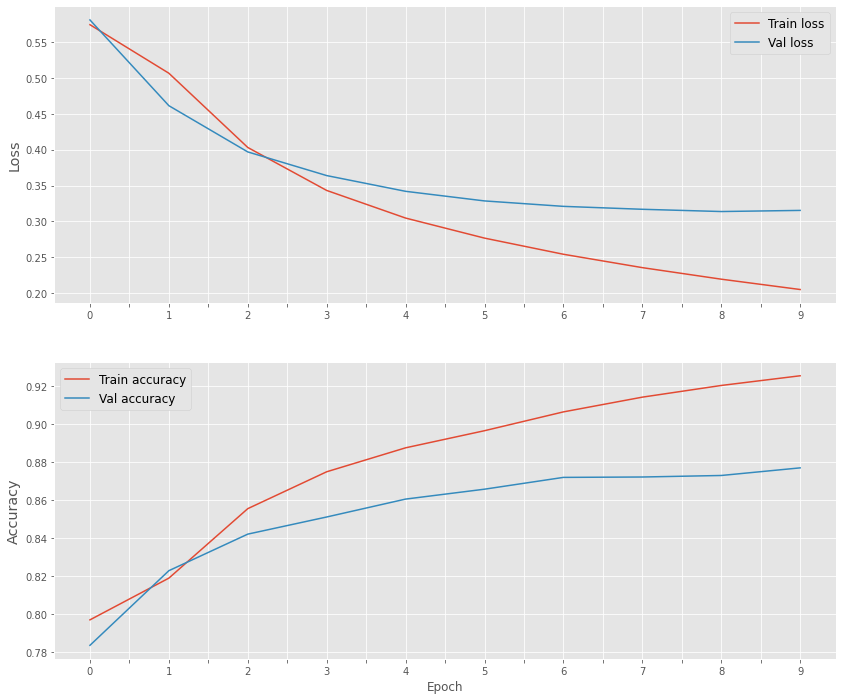

In [10]:
# Plot training history

history.plot_history()

In [11]:
# Evaluate on test data
test_preds = model.get_predictions(X_test)
test_labels = y_test[:test_preds.shape[0]]
test_loss = BinaryCrossEntropy()(test_labels, test_preds)
binary_preds = np.round(test_preds)
test_acc = np.mean(binary_preds == test_labels)


print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.2%}')


Test Loss: 0.3241
Test Accuracy: 86.37%
